In [8]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from pydicom.dataset import Dataset, FileDataset
from pydicom.sequence import Sequence
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import os

In [9]:
folder_path = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT"
dicom_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.dcm')]

dicom_slices = []
for file in dicom_files:
    file_path = os.path.join(folder_path, file)
    ds = pydicom.dcmread(file_path)
    dicom_slices.append(ds)

print(f"Loaded {len(dicom_slices)} DICOM files.")

Loaded 248 DICOM files.


In [10]:
# Load the middle slice for demonstration
middle_index = len(dicom_files) // 2
middle_slice_path = os.path.join(folder_path, dicom_files[middle_index])
ct_slice = pydicom.dcmread(middle_slice_path)

print(f"Patient ID: {ct_slice.PatientID}")
print(f"Modality: {ct_slice.Modality}")
print(f"Slice Location: {ct_slice.SliceLocation}")
print(f"Pixel Spacing: {ct_slice.PixelSpacing}")

Patient ID: ZZ_DD_HIP4
Modality: CT
Slice Location: -203.000
Pixel Spacing: [0.976562, 0.976562]


In [13]:
def get_hu_values(ct_slice):
    # Get pixel values and convert to Hounsfield Units (HU)
    pixel_array = ct_slice.pixel_array
    intercept = ct_slice.RescaleIntercept
    slope = ct_slice.RescaleSlope
    hu_values = pixel_array * slope + intercept
    return hu_values

# ...existing code...
hu_image = get_hu_values(ct_slice)
print(hu_image)
print(hu_image.size)

# Save HU values to a text file
np.savetxt("HIP4 pixel values.txt", hu_image, fmt="%.2f")
# ...existing code...

[[-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 ...
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]]
262144


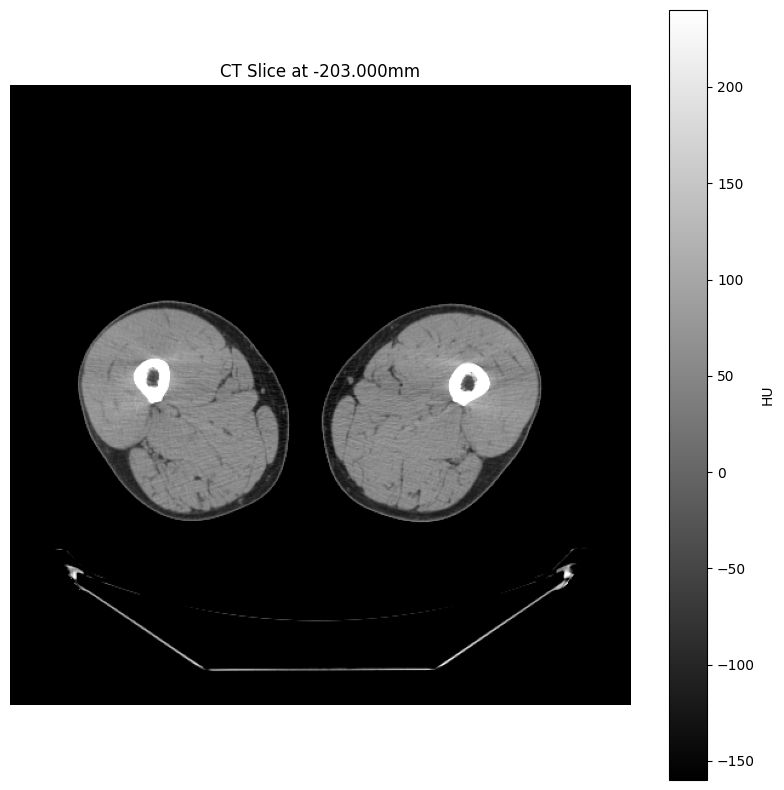

In [14]:
# Set window/level for better visualization (lung window)
window_center = 40  # Center of the window in HU
window_width = 400   # Width of the window in HU
min_value = window_center - window_width/2
max_value = window_center + window_width/2
hu_image_windowed = np.clip(hu_image, min_value, max_value)

# Common window/level presets:
# - Lung: -600/1500 (shows air-filled structures)
# - Soft tissue: 40/400 (optimal for organs)
# - Bone: 500/2000 (best for visualizing bones)
# - Brain: 40/80 (for brain tissue contrast)

# Display image
plt.figure(figsize=(10, 10))
plt.imshow(hu_image_windowed, cmap='gray')
plt.title(f"CT Slice at {ct_slice.SliceLocation}mm")
plt.axis('off')
plt.colorbar(label='HU')
plt.show()

In [17]:
# Function to display DICOM tags in a user-friendly way
def explore_dicom_tags(ds, max_depth=2, current_depth=0, prefix=''):
    """
    Recursively explore DICOM tags with controlled depth
    
    Parameters:
        ds: The DICOM dataset to explore
        max_depth: Maximum recursion depth for nested sequences (default=2)
                   Controls how deep to go into nested DICOM sequences:
                   - 0: Only show top-level tags
                   - 1: Show one level of sequence items
                   - 2+: Show deeper nested sequences
        current_depth: Current recursion depth (used internally)
        prefix: String prefix for indentation (used internally)
    
    Returns:
        List of formatted tag descriptions
    """
    tags_info = []
    
    # Skip Pixel Data because it's too large
    skip_tags = [(0x7FE0, 0x0010)]  # Pixel Data (the information required to rebuild/show the image)
    
    for elem in ds:
        if elem.tag in skip_tags:
            tags_info.append(f"{prefix}{elem.tag}: [Pixel Data]")
            continue
            
        # Format the element
        if elem.VR == "SQ":  # Sequence
            tags_info.append(f"{prefix}{elem.tag} {elem.name}: Sequence with {len(elem.value)} item(s)")
            if current_depth < max_depth:
                for i, item in enumerate(elem.value):
                    tags_info.append(f"{prefix}  Item {i}:")
                    tags_info.extend(explore_dicom_tags(item, max_depth, current_depth + 1, prefix + '    '))
        else:
            if elem.VM > 1:  # Multiple values
                tags_info.append(f"{prefix}{elem.tag} {elem.name}: {elem.repval}")
            else:
                tags_info.append(f"{prefix}{elem.tag} {elem.name}: {elem.repval}")
    
    return tags_info

# Display the first 20 tags
tags = explore_dicom_tags(ct_slice, max_depth=1)
for tag in tags[:20]:
    print(tag)

print("...")
print(f"Total tags: {len(tags)}")

(0008,0005) Specific Character Set: 'ISO_IR 100'
(0008,0008) Image Type: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0012) Instance Creation Date: '20250227'
(0008,0013) Instance Creation Time: '104318'
(0008,0016) SOP Class UID: CT Image Storage
(0008,0018) SOP Instance UID: 2.16.840.1.114362.1.12177026.23360333229.707356547.1018.3062
(0008,0020) Study Date: '20250227'
(0008,0021) Series Date: '20250227'
(0008,0022) Acquisition Date: '20250227'
(0008,0023) Content Date: '20250227'
(0008,0030) Study Time: '103622'
(0008,0031) Series Time: '104204'
(0008,0032) Acquisition Time: '104220.908397'
(0008,0033) Content Time: '104318'
(0008,0050) Accession Number: ''
(0008,0060) Modality: 'CT'
(0008,0070) Manufacturer: 'GE MEDICAL SYSTEMS'
(0008,0080) Institution Name: ''
(0008,0090) Referring Physician's Name: ''
(0008,1030) Study Description: 'RTP: Simulation: Complex- three or more treatment areas Adaptive'
...
Total tags: 90


In [19]:
rs_file = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 RSTRUCT\2.16.840.1.114362.1.12177026.23360333229.708561731.777.13.dcm"

In [30]:
rs = pydicom.dcmread(rs_file)
print(f"Structure Set Label: {rs.StructureSetLabel}")
print(f"Structure Set Date: {rs.StructureSetDate}")

# List all structures in the structure set
roi_sequences = rs.StructureSetROISequence
print(f"Number of ROIs: {len(roi_sequences)}")

structures = []
for roi in roi_sequences:
    structures.append({
        'ROI Number': roi.ROINumber,
        'ROI Name': roi.ROIName,
        'ROI Description': roi.ROIDescription if 'ROIDescription' in roi else 'N/A'
    })

df = pd.DataFrame(structures)
print(df)

Structure Set Label: RTstruct
Structure Set Date: 20250624
Number of ROIs: 3
   ROI Number ROI Name ROI Description
0           1    ROI-1                
1           3    ROI-2                
2           5    ROI-3                


In [40]:
# --- Utility Function: Get HU data from all DICOM slices in a folder ---
def get_hu_images_from_folder(folder_path):
    """Loads all DICOM files in a folder and returns a list of HU images and their metadata."""
    import os
    hu_images = []
    metas = []
    dicom_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.dcm')]
    for file in dicom_files:
        dicom_filepath = os.path.join(folder_path, file)
        try:
            ds = pydicom.dcmread(dicom_filepath)
            if 'PixelData' not in ds:
                print(f"Warning: No pixel data in {dicom_filepath}")
                continue
            raw_pixel_array = ds.pixel_array
            rescale_slope = getattr(ds, 'RescaleSlope', 1)
            rescale_intercept = getattr(ds, 'RescaleIntercept', 0)
            hu_array = raw_pixel_array * rescale_slope + rescale_intercept
            image_position = ds.ImagePositionPatient
            pixel_spacing = ds.PixelSpacing
            rows, cols = ds.Rows, ds.Columns
            metas.append({'ImagePositionPatient': image_position,
                          'PixelSpacing': pixel_spacing,
                          'Rows': rows, 'Cols': cols,
                          'SOPInstanceUID': ds.SOPInstanceUID,
                          'Filename': file})
            hu_images.append(hu_array)
        except Exception as e:
            print(f"Error reading DICOM {dicom_filepath}: {e}")
            continue
    return hu_images, metas

# --- Main function to overlay RTSTRUCT ---

    print(f"Attempting to overlay RTSTRUCT from '{my_rtstruct_file_path}' onto CT slice '{my_ct_slice_path}'")
    overlay_rtstruct_on_ct(my_ct_slice_path, my_rtstruct_file_path)

In [39]:
get_hu_image(r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT")

Error reading DICOM C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT: [Errno 13] Permission denied: 'C:\\Users\\david\\OneDrive\\Documents\\GitHub\\General\\HIP4 Patient\\HIP4 CT'


(None, None)

In [34]:
def overlay_rtstruct_on_ct(ct_file_path, rtstruct_file_path):
    """
    Loads a CT slice and an RTSTRUCT file, then overlays contours.
    This example is simplified for a single CT slice matching a contour.
    For a full series, precise 3D matching and iteration are needed.
    """
    hu_image, ct_meta = get_hu_image(ct_file_path)
    if hu_image is None:
        print("Could not load CT image. Exiting.")
        return

    try:
        rt_ds = pydicom.dcmread(rtstruct_file_path)
    except Exception as e:
        print(f"Error reading RTSTRUCT {rtstruct_file_path}: {e}")
        return

    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    # Display the CT image
    plt.imshow(hu_image, cmap=plt.cm.gray, vmin=-100, vmax=300) # Common soft tissue window
    plt.title("CT Image with RTSTRUCT Contours")
    plt.axis('off')

    # Iterate through all Structures (ROIs) in the RTSTRUCT file
    roi_names = {}
    if 'RTROIObservationsSequence' in rt_ds:
        roi_names = {item.ReferencedROINumber: item.RTROIInterpretedType
                     for item in rt_ds.RTROIObservationsSequence}
    # Fallback to ROIName if RTROIInterpretedType is not preferred or available
    elif 'StructureSetROISequence' in rt_ds:
        roi_names = {item.ROINumber: item.ROIName
                     for item in rt_ds.StructureSetROISequence}

    if 'ROIContourSequence' in rt_ds:
        for roi_contour_seq_item in rt_ds.ROIContourSequence:
            roi_number = roi_contour_seq_item.ReferencedROINumber
            roi_name = roi_names.get(roi_number, f"ROI_{roi_number}")

            # Check if there are contours defined for this ROI
            if 'ContourSequence' not in roi_contour_seq_item:
                continue

            for contour_seq_item in roi_contour_seq_item.ContourSequence:
                # Get the contour data (x, y, z coordinates)
                contour_data = np.array(contour_seq_item.ContourData).reshape(-1, 3) # Reshape into (N, 3)

                # Get the Z-coordinate of this contour
                contour_z = contour_data[0, 2] # All points in a single contour should have the same Z

                # Simplified Z-match for a single slice:
                # In a full 3D implementation, you'd match contour_z to the exact slice_location
                # or check if it falls within the slice thickness of a given CT slice.
                ct_slice_z = ct_meta['ImagePositionPatient'][2]

                # A simple check for matching Z, considering potential floating point inaccuracies
                if abs(contour_z - ct_slice_z) > (ct_meta['PixelSpacing'][2] / 2 if len(ct_meta['PixelSpacing']) > 2 else 1.5): # Use a small tolerance, like half slice thickness
                    # If this contour is not on the current slice, skip it.
                    # For a 3D series, you'd find the correct slice and plot on that one.
                    continue

                # Convert patient coordinates (mm) to pixel coordinates
                # X_pixel = (X_patient - ImagePositionPatient[0]) / PixelSpacing[0]
                # Y_pixel = (Y_patient - ImagePositionPatient[1]) / PixelSpacing[1]
                
                x_pixels = (contour_data[:, 0] - ct_meta['ImagePositionPatient'][0]) / ct_meta['PixelSpacing'][0]
                y_pixels = (contour_data[:, 1] - ct_meta['ImagePositionPatient'][1]) / ct_meta['PixelSpacing'][1]

                # Create a path for the contour
                path_points = np.column_stack([x_pixels, y_pixels])
                path = Path(path_points)
                
                # Create a patch to draw the contour
                # You can customize color per ROI or use a cycle of colors
                patch = PathPatch(path, facecolor='none', edgecolor='red', linewidth=1.5, label=roi_name)
                ax.add_patch(patch)
                
                print(f"Overlayed contour '{roi_name}' on slice at Z={ct_meta['ImagePositionPatient'][2]:.2f}")
                
        # Optional: Add a legend if multiple contours are drawn
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            # Filter out duplicate labels (if an ROI has multiple contours on same slice, they'd be redundant)
            unique_labels_map = {}
            for h, l in zip(handles, labels):
                unique_labels_map[l] = h # Last one wins if duplicate label
            
            unique_handles = list(unique_labels_map.values())
            unique_labels = list(unique_labels_map.keys())
            
            plt.legend(unique_handles, unique_labels, loc='upper right', bbox_to_anchor=(1.25, 1))

    else:
        print("No ROIContourSequence found in RTSTRUCT file.")

    plt.tight_layout()
    plt.show()